code by **PAUL ANTONY**

**Importing necessary libraries and dataset from repository.**
Dataset was firstly combined and afterwards cleaned within the team. Following Hypothesis 2 "Posts including pictures and videos generate higher engagement levels (likes, comments, shares) compared to posts without those elements on US Theme Park Facebook profiles." will be checked within this Python File.


In [331]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
from tabulate import tabulate
import re
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

#loading our cleaned dataset
df = pd.read_csv('combined_themepark_dataset.csv')
df_original_len = len(df)
print('Original length of dataframe:', df_original_len)

Original length of dataframe: 15443


In [332]:
df.head(1)

,date,profile,message,nr_reactions,nr_comments,nr_shares,comments/post,post_interaction_rate,engagement,nr_likes,link_posts,picture_posts,video_posts,profile_id,post_id,link
0,12/31/23 9:40 PM,Wild Adventures Theme Park,🎟️🚨 Today's the FINAL day to use your 2023 Sea...,16,2,2,2,"1,09E+12","1,09E+12",13,NaN,1.0,NaN,84679583132,84679583132_770120045161180,https://www.facebook.com/617429960430190/posts...


**Main Research Question of the Report:** What strategies can US theme parks employ to enhance audience engagement based on insights from performance analysis on Facebook posts? <br>
**Sub-Research Question for Hypothesis 2:** What impact do different types of posts (link, picture, video) have on the engagement levels of US Theme Park Facebook profiles? 

# Testing Hypothesis 2

* H0: Posts including pictures and videos generate higher engagement levels (likes, comments, shares) compared to posts without those elements on US Theme Park Facebook profiles.
* HA: Posts including pictures and videos generate lower engagement levels (likes, comments, shares) compared to posts without those elements on US Theme Park Facebook profiles.

In [333]:
#check if there are rows without data
df.isnull().sum()

date                         0
profile                      0
message                      0
nr_reactions                 0
nr_comments                  0
nr_shares                    0
comments/post                0
post_interaction_rate        0
engagement                   0
nr_likes                     0
link_posts               14888
picture_posts             3881
video_posts              12964
profile_id                   0
post_id                      0
link                         0
dtype: int64

In [334]:
#check data types
df.dtypes

date                      object
profile                   object
message                   object
nr_reactions               int64
nr_comments                int64
nr_shares                  int64
comments/post              int64
post_interaction_rate     object
engagement                object
nr_likes                   int64
link_posts               float64
picture_posts            float64
video_posts              float64
profile_id                object
post_id                   object
link                      object
dtype: object

In [335]:
#list of column names to drop
columns_to_drop = ['message', 'date', 'profile_id', 'post_id', 'link',]
#remove specified columns
df = df.drop(columns=columns_to_drop)

When examining the data type, it was found that there are a lot of missing values in the columns 'picture_posts' and 'video_posts'. This has to do with the fact that if it was a picture post, for example, the value 1 was assigned, on the other hand a NaN value remained. 

As a next log-safe step, I will now generate a new feature that combines this information. So if it is a picture post, the value 1 is assigned. If it is a video post, the value 2 and if the post does not contain an image or video, the value 3.

In [336]:
#setting conditions for the columns
conditions = [
    ~df['picture_posts'].isna(),  # Not NaN for Picture Posts
    ~df['video_posts'].isna()     # Not NaN for Video-posts
]

#updated values to assign based on the conditions: 1 for picture_posts, 2 for video_posts
values = [1, 2]

#create the new column 'post_type' with an 'other' category for everything else except picture and video posts
df['post_type'] = np.select(conditions, values, default=3)

#display the first few rows of the dataframe to verify the new column
df[['picture_posts', 'video_posts', 'post_type']].head()


,picture_posts,video_posts,post_type
0,1.0,NaN,1
1,NaN,NaN,3
2,NaN,1.0,2
3,1.0,NaN,1
4,NaN,1.0,2


In [337]:
#counting the occurrences of 1, 2, and 3 in the 'post_type' column
post_type_counts = df['post_type'].value_counts()
#displaying the counts
print(post_type_counts)

post_type
1    11562
2     2479
3     1402
Name: count, dtype: int64


So we can see, that there are `11562` columns containing picture_posts, `2479` columns containing video_posts and `1402` without any of those.

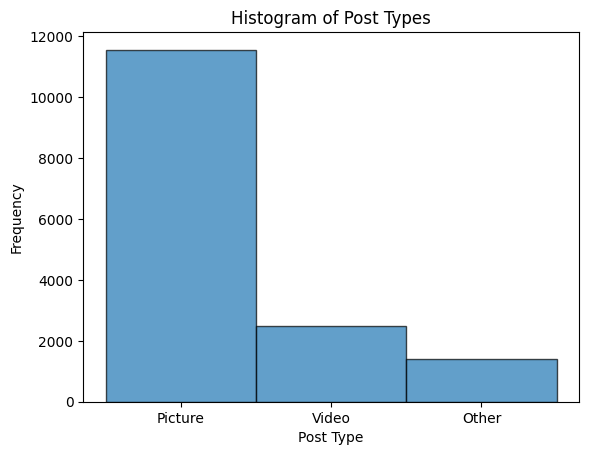

In [338]:
#plotting the histogram for the 'post_type' column
plt.hist(df['post_type'], bins=[0.5, 1.5, 2.5, 3.5], edgecolor='black', alpha=0.7)

#setting the x-ticks to correspond to the updated post types
plt.xticks(ticks=[1, 2, 3], labels=['Picture', 'Video', 'Other'])

#setting title and labels
plt.title('Histogram of Post Types')
plt.xlabel('Post Type')
plt.ylabel('Frequency')

#displaying the plot
plt.show()

In [339]:
#dropping the specified columns from the DataFrame
df = df.drop(columns=['link_posts', 'picture_posts', 'video_posts'])

In [340]:
#display df in a formatted table
print(tabulate(df.head(), headers='keys', tablefmt='fancy_grid'))

╒════╤════════════════════════════╤════════════════╤═══════════════╤═════════════╤═════════════════╤═════════════════════════╤══════════════╤════════════╤═════════════╕
│    │ profile                    │   nr_reactions │   nr_comments │   nr_shares │   comments/post │ post_interaction_rate   │ engagement   │   nr_likes │   post_type │
╞════╪════════════════════════════╪════════════════╪═══════════════╪═════════════╪═════════════════╪═════════════════════════╪══════════════╪════════════╪═════════════╡
│  0 │ Wild Adventures Theme Park │             16 │             2 │           2 │               2 │ 1,09E+12                │ 1,09E+12     │         13 │           1 │
├────┼────────────────────────────┼────────────────┼───────────────┼─────────────┼─────────────────┼─────────────────────────┼──────────────┼────────────┼─────────────┤
│  1 │ Fun Spot America           │             38 │             1 │           2 │               1 │ 4,17E+11                │ 4,17E+11     │         33 │ 

In [341]:
# Weights for each type of interaction
weights = {
    'likes': 1,
    'comments': 2,
    'shares': 3
}

# Calculate the engagement score
df['engagement_score'] = (
    weights['likes'] * df['nr_likes'] +
    weights['comments'] * df['nr_comments'] +
    weights['shares'] * df['nr_shares']
)

# Displaying the first few rows to verify the new column
df.head()


,profile,nr_reactions,nr_comments,nr_shares,comments/post,post_interaction_rate,engagement,nr_likes,post_type,engagement_score
0,Wild Adventures Theme Park,16,2,2,2,"1,09E+12","1,09E+12",13,1,23
1,Fun Spot America,38,1,2,1,"4,17E+11","4,17E+11",33,3,41
2,Fun Spot America,23,2,3,2,"2,85E+11","2,85E+11",21,2,34
3,Disneyland Paris,646,52,12,56,"1,36E+11","1,36E+11",478,1,618
4,Silverwood Theme Park,17,2,0,2,"4,96E+11","4,96E+11",16,2,20


In [342]:
# Calculate Total Interactions (Engagement)
df['engagement_score2'] = df['nr_reactions'].fillna(0) + df['nr_shares'].fillna(0) + df['nr_comments'].fillna(0)

# Displaying the calculated engagement metric along with other relevant columns
print(df[['profile', 'post_type','engagement_score2']])

                                         profile  post_type  engagement_score2
0                     Wild Adventures Theme Park          1                 20
1                               Fun Spot America          3                 41
2                               Fun Spot America          2                 28
3                               Disneyland Paris          1                710
4                          Silverwood Theme Park          2                 19
...                                          ...        ...                ...
15438                 Wild Adventures Theme Park          1                 21
15439                                   Playland          1                  8
15440                           Disneyland Paris          2                904
15441  Six Flags Over Georgia & Hurricane Harbor          1                 67
15442                         Knott's Berry Farm          1                510

[15443 rows x 3 columns]


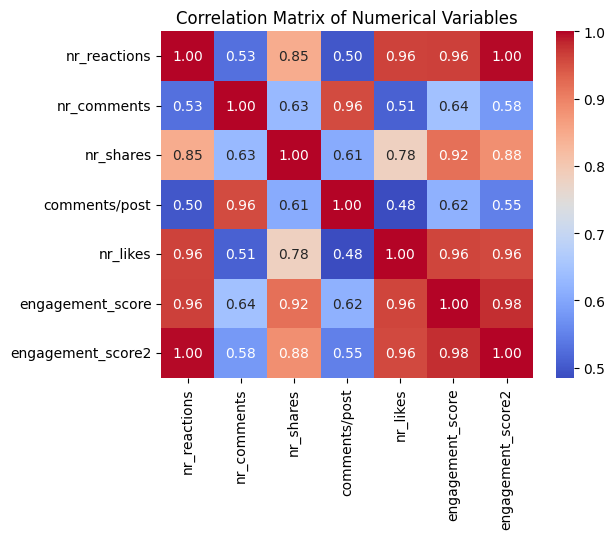

In [343]:
#preperation for correlation analysis on numerical columns, include all the float and int
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_cols].corr()
numerical_cols

#plotting the correlation matrix
plt.figure(figsize=(6, 4.5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

In [344]:
df.head()

,profile,nr_reactions,nr_comments,nr_shares,comments/post,post_interaction_rate,engagement,nr_likes,post_type,engagement_score,engagement_score2
0,Wild Adventures Theme Park,16,2,2,2,"1,09E+12","1,09E+12",13,1,23,20
1,Fun Spot America,38,1,2,1,"4,17E+11","4,17E+11",33,3,41,41
2,Fun Spot America,23,2,3,2,"2,85E+11","2,85E+11",21,2,34,28
3,Disneyland Paris,646,52,12,56,"1,36E+11","1,36E+11",478,1,618,710
4,Silverwood Theme Park,17,2,0,2,"4,96E+11","4,96E+11",16,2,20,19


### Check Assumptions for the Two-Sample T-Test and ANOVA:
**Assumptions for Two-Sample T-Test:**
* Independence of Observations: The data in the two groups must be independent of each other, meaning the observations in one group should not influence the observations in the other group.

* Normality: The data in both groups should be approximately normally distributed. This assumption can be relaxed with large sample sizes due to the Central Limit Theorem.

* Homogeneity of Variances (Equal Variances): The variances in the two groups should be roughly equal. If this assumption is not met, a variation of the t-test called Welch’s t-test can be used, which does not assume equal variances.

* Scale of Measurement: The variable being tested should be measured on an interval or ratio scale (i.e., continuous data).

* Random Sampling: The data should be collected from a random sample from the population.

In [345]:
# Normality test
print(stats.shapiro(df[df['post_type'] == 1]['engagement_score']))  # Picture posts
print(stats.shapiro(df[df['post_type'] == 2]['engagement_score']))  # Video posts
print(stats.shapiro(df[df['post_type'] == 3]['engagement_score']))  # Other posts

ShapiroResult(statistic=0.19004195928573608, pvalue=0.0)
ShapiroResult(statistic=0.11915314197540283, pvalue=0.0)
ShapiroResult(statistic=0.06499040126800537, pvalue=0.0)


c:\Users\paula\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [346]:
# Normality test 2
print(stats.shapiro(df[df['post_type'] == 1]['engagement_score2']))  # Picture posts
print(stats.shapiro(df[df['post_type'] == 2]['engagement_score2']))  # Video posts
print(stats.shapiro(df[df['post_type'] == 3]['engagement_score2']))  # Other posts

ShapiroResult(statistic=0.1960843801498413, pvalue=0.0)
ShapiroResult(statistic=0.11290872097015381, pvalue=0.0)
ShapiroResult(statistic=0.05915111303329468, pvalue=0.0)


In [347]:
# Variance equality test
print(stats.levene(
    df[df['post_type'] == 1]['engagement_score'],
    df[df['post_type'] == 2]['engagement_score'],
    df[df['post_type'] == 3]['engagement_score']
))


LeveneResult(statistic=46.05307686033495, pvalue=1.1450453253788721e-20)


**Assumptions for ANOVA:**
* Independence of Observations: Just like in the two-sample t-test, the observations in each group must be independent of each other.

* Normality: The distribution of the residuals should be approximately normal for each group. This means that the data in each group should come from a population that follows a normal distribution.

* Homogeneity of Variances: The variance among the groups should be approximately equal. This is known as the assumption of homoscedasticity. If this assumption is violated, alternatives like the Welch ANOVA or the Brown-Forsythe test can be considered.

* Random Sampling: Each sample should be an independent random sample from the population.

* Measurement Scale: The dependent variable should be measured at the interval or ratio level.

### Two-Sample T-Test

In [348]:
from scipy.stats import ttest_ind

# Combine picture and video posts into one group
picture_video_engagement = df[(df['post_type'] == 1) | (df['post_type'] == 2)]['engagement_score2'].dropna()

# 'Other' posts group
other_engagement = df[df['post_type'] == 3]['engagement_score2'].dropna()

# Perform two-sample t-test
t_stat, p_value = ttest_ind(picture_video_engagement, other_engagement, equal_var=False)

# Display t-test results
print("Two-sample t-test Results:")
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("The p-value is less than", alpha, "so we reject the null hypothesis.")
    print("There is evidence to suggest that posts with pictures and videos have different engagement levels compared to posts without those elements.")
else:
    print("The p-value is greater than or equal to", alpha, "so we fail to reject the null hypothesis.")
    print("There is no significant evidence to suggest that the presence of pictures or videos affects engagement levels in Facebook posts.")


Two-sample t-test Results:
t-statistic: 1.0776974439795517
p-value: 0.2813241353226942
The p-value is greater than or equal to 0.05 so we fail to reject the null hypothesis.
There is no significant evidence to suggest that the presence of pictures or videos affects engagement levels in Facebook posts.


t-statistic: 1.0776974439795517
p-value: 0.2812341353226942
The t-statistic is a measure of the difference between the two groups in terms of their mean engagement score, relative to the spread or variability of their scores. A t-statistic value of around 1.08 suggests that there is a small difference in the mean engagement scores of posts with pictures/videos and posts without them.

The p-value tells us about the probability of observing a t-statistic as extreme as, or more extreme than, the one calculated from your data, under the assumption that the null hypothesis is true. The null hypothesis, in this case, is that there is no difference in engagement between posts with pictures/videos and those without.

Since the p-value is approximately 0.281, which is greater than the common alpha level of 0.05 used to denote statistical significance, you do not have enough evidence to reject the null hypothesis. This means that, according to your data and the t-test analysis, there is no statistically significant evidence to suggest that the presence of pictures or videos affects engagement levels in Facebook posts from US Theme Park profiles.\

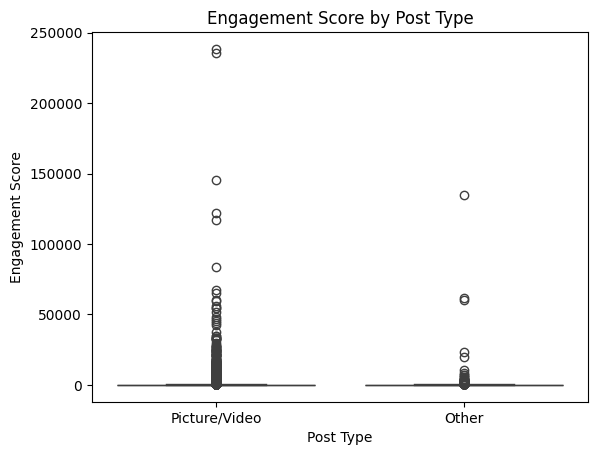

In [349]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the groups into a single DataFrame for visualization
picture_video_engagement_df = df[(df['post_type'] == 1) | (df['post_type'] == 2)][['engagement_score2']]
picture_video_engagement_df['Post Type'] = 'Picture/Video'
other_engagement_df = df[df['post_type'] == 3][['engagement_score2']]
other_engagement_df['Post Type'] = 'Other'

# Concatenate the two DataFrames
combined_df = pd.concat([picture_video_engagement_df, other_engagement_df])

# Plot
sns.boxplot(x='Post Type', y='engagement_score2', data=combined_df)
plt.title('Engagement Score by Post Type')
plt.xlabel('Post Type')
plt.ylabel('Engagement Score')
plt.show()


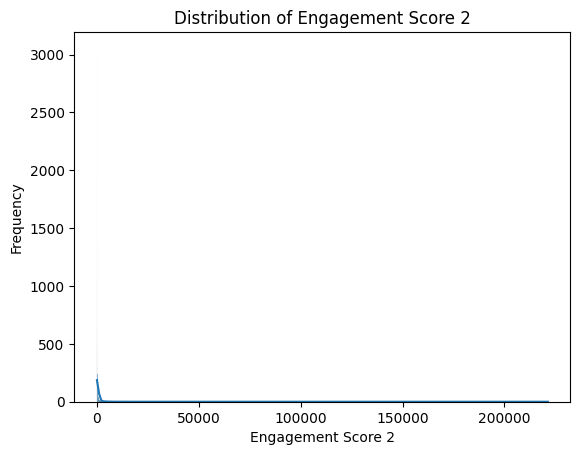

In [350]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your dataframe and 'engagement_score2' is the column you want to plot
sns.histplot(df['engagement_score'].dropna(), kde=True)

plt.title('Distribution of Engagement Score 2')
plt.xlabel('Engagement Score 2')
plt.ylabel('Frequency')
plt.show()


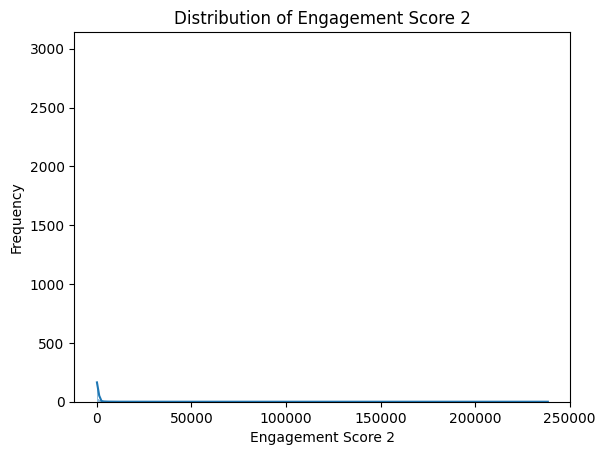

In [351]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your dataframe and 'engagement_score2' is the column you want to plot
sns.histplot(df['engagement_score2'].dropna(), kde=True)

plt.title('Distribution of Engagement Score 2')
plt.xlabel('Engagement Score 2')
plt.ylabel('Frequency')
plt.show()


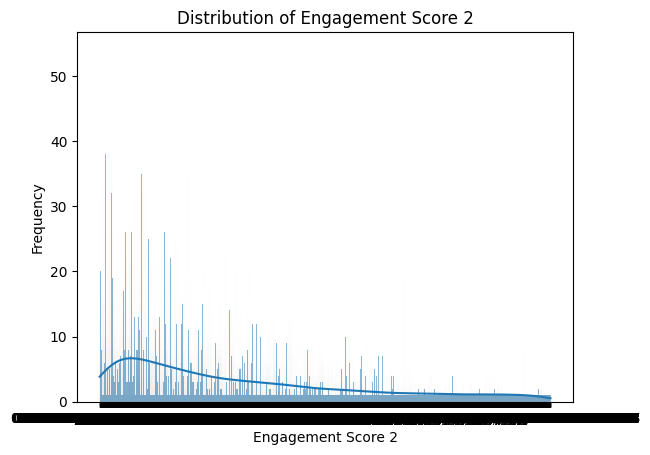

In [352]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your dataframe and 'engagement_score2' is the column you want to plot
sns.histplot(df['engagement'].dropna(), kde=True)

plt.title('Distribution of Engagement Score 2')
plt.xlabel('Engagement Score 2')
plt.ylabel('Frequency')
plt.show()


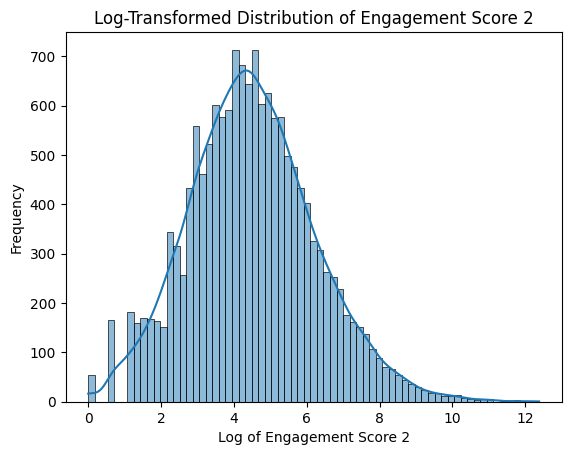

In [353]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame and 'engagement_score2' is the column with the engagement scores
# Apply log transformation, adding 1 to avoid log(0) which is undefined
df['log_engagement_score2'] = np.log1p(df['engagement_score2'])

# Plot the distribution of the log-transformed engagement scores
sns.histplot(df['log_engagement_score2'].dropna(), kde=True)

plt.title('Log-Transformed Distribution of Engagement Score 2')
plt.xlabel('Log of Engagement Score 2')
plt.ylabel('Frequency')
plt.show()


In [354]:
from scipy.stats import shapiro

# Apply the Shapiro-Wilk test on the original engagement_score2 column
# Assuming 'df' is your DataFrame and 'engagement_score2' is your column
stat, p = shapiro(df['engagement_score2'].dropna())

# Print the test statistic and the p-value
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p)

# Interpret the results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Shapiro-Wilk Test Statistic: 0.08507466316223145
p-value: 0.0
Sample does not look Gaussian (reject H0)


c:\Users\paula\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### ANOVA

In [355]:
# ANOVA test
print(stats.f_oneway(
    df[df['post_type'] == 1]['engagement_score'],
    df[df['post_type'] == 2]['engagement_score'],
    df[df['post_type'] == 3]['engagement_score']
))


F_onewayResult(statistic=47.713016133588255, pvalue=2.199235689354772e-21)


In [356]:
# Kruskal-Wallis test
print(stats.kruskal(
    df[df['post_type'] == 1]['engagement_score'],
    df[df['post_type'] == 2]['engagement_score'],
    df[df['post_type'] == 3]['engagement_score']
))


KruskalResult(statistic=163.56557268807484, pvalue=3.035199039509937e-36)


In [357]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Assuming the ANOVA was significant
tukey = pairwise_tukeyhsd(endog=df['engagement_score'], groups=df['post_type'], alpha=0.05)
print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower      upper   reject
---------------------------------------------------------
     1      2  869.8692   0.0   660.6391 1079.0993   True
     1      3   76.5939  0.78   -190.743  343.9308  False
     2      3 -793.2753   0.0 -1109.1679 -477.3827   True
---------------------------------------------------------


In [358]:
import pandas as pd
from scipy.stats import f_oneway

# Perform ANOVA test
result = f_oneway(
    df[df['post_type'] == 1]['engagement_score2'].dropna(),
    df[df['post_type'] == 2]['engagement_score2'].dropna(),
    df[df['post_type'] == 3]['engagement_score2'].dropna()
)

# Display ANOVA test results
print("ANOVA Test Results:")
print("F-statistic:", result.statistic)
print("p-value:", result.pvalue)

# Interpret the results
alpha = 0.05  # significance level
if result.pvalue < alpha:
    print("The p-value is less than", alpha, "so we reject the null hypothesis.")
    print("There is evidence to suggest that post type significantly affects user engagement in Facebook posts.")
else:
    print("The p-value is greater than or equal to", alpha, "so we fail to reject the null hypothesis.")
    print("There is no significant evidence to suggest that post type affects user engagement in Facebook posts.")


ANOVA Test Results:
F-statistic: 53.665833996392486
p-value: 5.941004203842008e-24
The p-value is less than 0.05 so we reject the null hypothesis.
There is evidence to suggest that post type significantly affects user engagement in Facebook posts.


In [359]:
from scipy.stats import mannwhitneyu

# Separate your data into two groups: one for posts with pictures/videos and one for posts without
group_with_media = df[(df['post_type'] == 1) | (df['post_type'] == 2)]['engagement_score2']
group_without_media = df[df['post_type'] == 3]['engagement_score2']

# Perform the Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(group_with_media, group_without_media, alternative='greater')

# Print the test statistic and p-value
print('Mann-Whitney U Test Statistic:', u_statistic)
print('p-value:', p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("We reject the null hypothesis. There is a statistically significant difference in engagement scores between posts with media and without.")
else:
    print("We fail to reject the null hypothesis. There is not a statistically significant difference in engagement scores between posts with media and without.")


Mann-Whitney U Test Statistic: 10993165.5
p-value: 2.4556010132096616e-13
We reject the null hypothesis. There is a statistically significant difference in engagement scores between posts with media and without.


In [360]:
from scipy.stats import mannwhitneyu

# Calculate the Mann-Whitney U test
group_with_media = df[(df['post_type'] == 1) | (df['post_type'] == 2)]['engagement_score2']
group_without_media = df[df['post_type'] == 3]['engagement_score2']

u_statistic, p_value = mannwhitneyu(group_with_media, group_without_media)

# Calculate the Common Language Effect Size (CLES)
n1 = len(group_with_media)
n2 = len(group_without_media)
cles = u_statistic / (n1 * n2)

# Print the CLES
print('Common Language Effect Size (CLES):', cles)

# Interpret the CLES
if cles > 0.5:
    print("A score picked at random from the group with media is more likely to be greater than a score picked from the group without media.")
elif cles < 0.5:
    print("A score picked at random from the group without media is more likely to be greater than a score picked from the group with media.")
else:
    print("There is a 50-50 chance that a score picked at random from one group will be greater than a score picked from the other group.")


Common Language Effect Size (CLES): 0.5584402505359025
A score picked at random from the group with media is more likely to be greater than a score picked from the group without media.
